# Predicting Pitch Type

---
embed-resources: true
---

## Introduction

In this report, we develop a model to predict a baseball's pitch type based on its characteristics in real time. This model only works for this dataset. This model also does not consider other factors that may affect the pitch such as wind speed.

## Methods

In [211]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# preprocessing imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

### Data

In [212]:
# load data
import pandas as pd
pitches_train = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-test.parquet",
)
pitches_vtrain, pitches_validation = train_test_split(
    pitches_train,
    test_size=0.35,
)
numeric = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
categorical = ['stand']
features = numeric + categorical
target = 'pitch_name'
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


We see that in the train data, each row represents the name of the type of pitch and its characteristics. The variables in this data set are:

### Response 

**`pitch_name`**

- [object] the name of the pitch, which is the name of the pitch type thrown

### Features

**`release_speed`**

- [float64] pitch velocity (miles per hour) measured shortly after leaving the pitcher’s hand
release_spin_rate

**`release_spin_rate`**

- [float64] pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher’s hand
pfx_x

**`pfx_x`**

- [float64] horizontal movement (feet) of the pitch from the catcher’s perspective.
pfx_z

**`pfx_z`**

- [float64] vertical movement (feet) of the pitch from the catcher’s perspective.
stand

**`stand`**

- [object] side of the plate batter is standing, either L (left) or R (right)



In [213]:
# summary statistics
pitch_group = pitches_train.groupby('pitch_name').count().reset_index()
porp = pitch_group['release_speed'] / 2628
porp

0    0.273212
1    0.084475
2    0.088661
3    0.036910
4    0.023973
5    0.118721
6    0.374049
Name: release_speed, dtype: float64

In [214]:
speed = pitches_train.groupby('pitch_name')['release_speed'].agg(['mean', 'std']).reset_index()
speed

,pitch_name,mean,std
0,4-Seam Fastball,97.270613,1.699270
1,Curveball,77.679730,3.215206
2,Cutter,90.742060,2.364489
3,Sinker,97.160825,1.829592
4,Slider,85.203175,2.401543
5,Split-Finger,89.291346,1.759299
6,Sweeper,85.336419,1.862552


In [215]:
spin = pitches_train.groupby('pitch_name')['release_spin_rate'].agg(['mean', 'std']).reset_index()
spin

,pitch_name,mean,std
0,4-Seam Fastball,2217.331933,114.754683
1,Curveball,2482.666667,119.854726
2,Cutter,2378.424893,206.685887
3,Sinker,1972.747368,143.920632
4,Slider,2497.619048,78.679306
5,Split-Finger,1273.560897,221.291146
6,Sweeper,2492.172940,103.176892


The summary statistics show the mean and STD of each pitch type's release speed and release spin rate.  

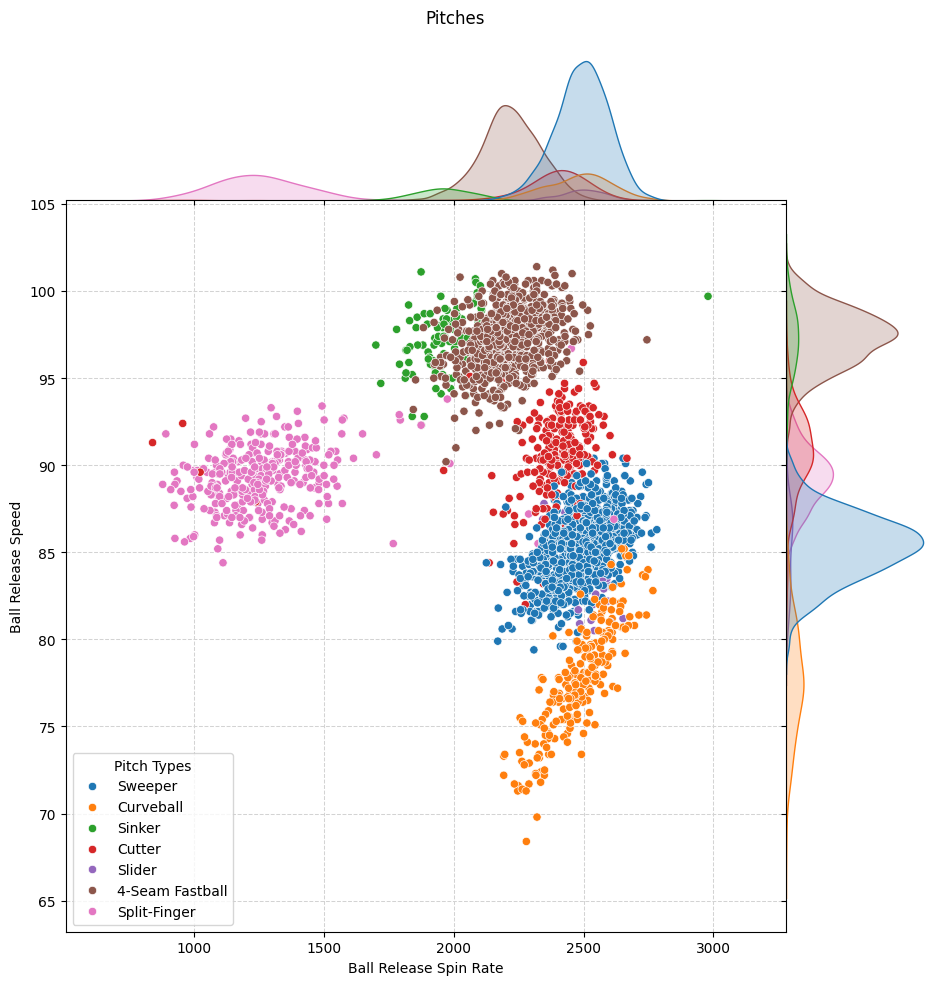

In [216]:
# exploratory visualization
plot = sns.jointplot(
    data=pitches_train,
    x="release_spin_rate",
    y="release_speed",
    hue="pitch_name",
    space=0,
    zorder=2,
)
plot.set_axis_labels(
    xlabel="Ball Release Spin Rate",
    ylabel="Ball Release Speed",
)
plot.figure.suptitle(
    t="Pitches",
    y=1.02,
)
plot.ax_joint.legend(
    title="Pitch Types",
    loc="lower left",
)
plot.ax_joint.grid(
    color="lightgrey",
    linestyle="--",
    linewidth=0.75,
    zorder=1,
)
plot.figure.set_size_inches(
    w=10,
    h=10,
)

From the plot above, each dot represents a pitch that was thrown. The color coordinated with it represents the type of pitch it is. Overall, the plot shows the relationship between the pitch's release spin rate and ball release speed while differentiating the different pitch types with different colors. This plot helps us see the different types of pitches and how each of them varies based on their spin rate and release speed.


### Models

In [217]:
# process data for ML
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

#create X and y for validation
X_validation = pitches_validation.drop('pitch_name', axis = 1)
y_validation = pitches_validation['pitch_name']

#create x and y for validation train
X_vtrain = pitches_vtrain.drop('pitch_name', axis = 1)
y_vtrain = pitches_vtrain['pitch_name']


We split the data once into train and test data and split the train data again into validation train sets and validation sets to get more accurate results



In [218]:
# train models
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

# define preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

# create general preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer, numeric),
    (categorical_transformer, categorical),
    remainder="drop",
)



In [236]:
validation_accuracy_scores = []
k_val_scores = [1, 5, 10, 15, 20, 25, 50, 100]
for k in k_val_scores:
    mod = make_pipeline(
        preprocessor,
        KNeighborsClassifier(n_neighbors=k),
    )
    mod.fit(X_vtrain, y_vtrain)
    y_pred = mod.predict(X_validation)
    validation_accuracy_score = accuracy_score(y_validation, y_pred)
    validation_accuracy_scores.append(validation_accuracy_score)

# get best k value
k_best = k_val_scores[np.argmax(validation_accuracy_scores)]

# validation results
validation_results = pd.DataFrame(
    {
        "k": k_val_scores,
        "Accuracy": validation_accuracy_scores,
    }
)
print(validation_results)
print(f"")
print(k_best)

     k  Accuracy
0    1  0.968478
1    5  0.972826
2   10  0.970652
3   15  0.970652
4   20  0.971739
5   25  0.973913
6   50  0.966304
7  100  0.951087

25


When using the model on the validation sets, we see the best k-value to use is 25 since it has an accuracy of 0.973913. This means that when the model uses 25 closest neighbors to make a prediction of the type of pitch, it correctly classified the pitch type 97.4% of the time.

## Results

In [220]:
# report model metrics
final_model = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_neighbors=k_best),
)
final_model.fit(X_train, y_train)

# predict on the test data
y_test_pred = final_model.predict(X_test)

# calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9403810694529809


When getting our best k-value to use, we fit it to the regular train data. After fitting the train data to the final model, we use the final model to predict our y_test data using the X_test data. After doing so, we get a test accuracy of 94.04%

## Discussion

Our final model on the test data gives us an accuracy score of 94.04% when trying to predict a pitch type based on its numeric characteristics. The accuracy score value represents the percentage of predictions that correctly classified a pitch and its type. This means that our final model predicted 94.04% of each pitch type correctly and 5.96% of the pitches incorrectly. So for example when a baseball is thrown, our model has a 94.04% chance of correctly predicting the pitch type based on its numeric statistics.


Even though our model achieves an impressive accuracy score of 94.04% I would not use this model in real game scenarios. An accuracy score of 94.04% is pretty good but accuracy alone is not sufficient enough for real-time game predictions. A 6% of error is still a pretty high percentage of getting a pitch type wrong. When using this model in a live baseball game, any misclassifications from the model could lead to huge consequences for strategic game decisions. For example, if the model were to incorrectly predict a pitch type in a close game, it could potentially cost the game for the team and lead to a loss.


In order to achieve a higher accuracy score, we can use and feed the model more data whether it can from past or future statistics. Doing this regularly with new data will help the model to adapt to continuous patterns that keep coming up.


The matrix below shows the numeric relationship between two features and the strengths between two variables. We can for example the correlation between release speed and pfx_x have a strong negative relationship. Meaning that as the horizontal movement of the pitchers feet increases, the release speed of the ball decreases and vice versa. Using this matrix can help us see strong relationships between two features and use those relationships for future models to make more accurate predictions. We can also remove weak relationships as well.


Overall, we should not use this final model because a 6% of predicting a pitch type incorrectly is too costly in real-game time especially if a game is close.



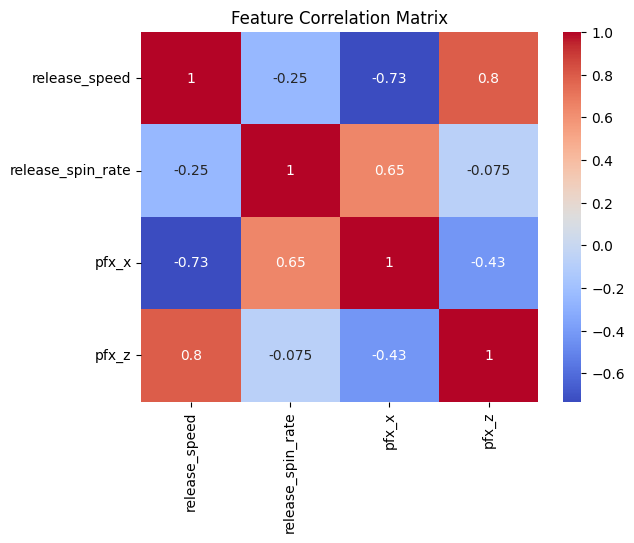

In [237]:
# Summary
corr_matrix = X_train[numeric].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [221]:
# serialize model
dump(final_model, "pitches.joblib")

['pitches.joblib']